Importing Omega_k!=0 package
Running Cosmo Check
NOTE: This cosmology still needs fixing - doesn't work for large values of Ode, but need to check if these are physical values anyway
complexity 0 cosmo_iter 0


/mnt/zfsusers/hollowayp/python11_env/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/mnt/zfsusers/hollowayp/python11_env/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


complexity 0 cosmo_iter 1
complexity 0 cosmo_iter 2
complexity 1 cosmo_iter 0
complexity 1 cosmo_iter 1
complexity 1 cosmo_iter 2
complexity 2 cosmo_iter 0
Failed Check: 
Cosmology: w0waCDM(H0=50.0 km / (Mpc s), Om0=0.20000000298023224, Ode0=1.7000000476837158, w0=-0.5, wa=-0.8999999761581421, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=None)


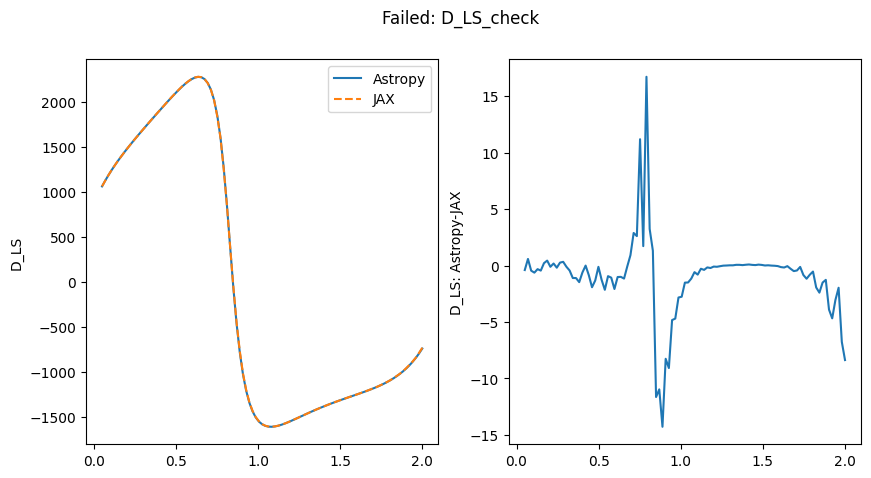

Failed Check (2) 
Cosmology: w0waCDM(H0=50.0 km / (Mpc s), Om0=0.20000000298023224, Ode0=1.7000000476837158, w0=-0.5, wa=-0.8999999761581421, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=None)


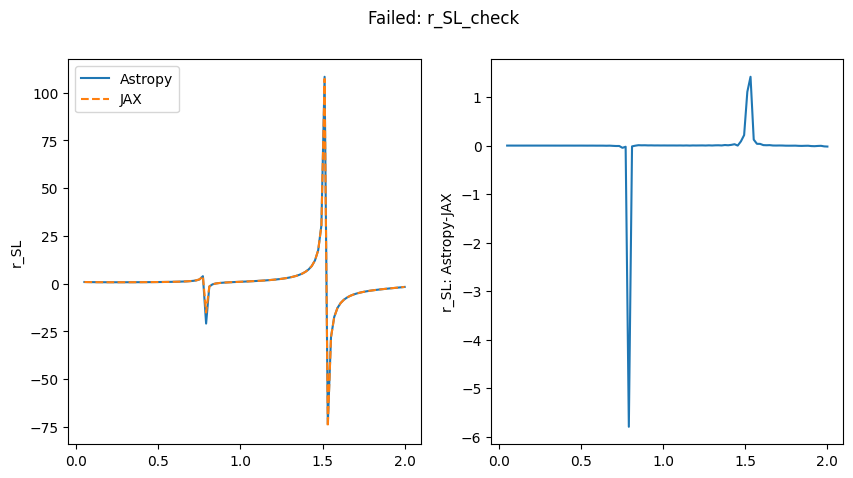

complexity 2 cosmo_iter 1
complexity 2 cosmo_iter 2
Importing Omega_k==0 package
Running Cosmo Check
NOTE: This cosmology still needs fixing - doesn't work for large values of Ode, but need to check if these are physical values anyway
complexity 0 cosmo_iter 0
complexity 0 cosmo_iter 1
complexity 0 cosmo_iter 2
complexity 1 cosmo_iter 0
complexity 1 cosmo_iter 1
complexity 1 cosmo_iter 2
complexity 2 cosmo_iter 0
complexity 2 cosmo_iter 1
complexity 2 cosmo_iter 2
Running Omega_k check


 69%|██████▉   | 162/234 [00:00<00:00, 976260.41it/s]


COMPS 1 cpu [CpuDevice(id=0)]
['/mnt/zfsusers/hollowayp/python11_env/lib/python3.11/site-packages/ipykernel_launcher.py', '--f=/mnt/zfsusers/hollowayp/.local/share/jupyter/runtime/kernel-v2-468igxHn7KzoVqk.json']
Contaminated True <class 'bool'> Photometric True <class 'bool'>
Filein --f=/mnt/zfsusers/hollowayp/.local/share/jupyter/runtime/kernel-v2-468igxHn7KzoVqk.json
Using 10000 samples with 100 as a warmup, and 2 chains in total.
Assuming the cosmology type is FlatLambdaCDM


In [1]:
#from tensorflow.python.client import device_lib
import os
os.chdir('/mnt/zfsusers/hollowayp/zBEAMS/')
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

#print('GPU',get_available_gpus())
from zbeamsfunctions_SL import likelihood_SL,likelihood_spec_contam_SL,likelihood_phot_contam_SL,likelihood_phot_SL,r_SL
from astropy.cosmology import LambdaCDM,FlatLambdaCDM,wCDM,FlatwCDM,w0waCDM
from zbeamsfunctions import mu_w,likelihood,likelihood_spec
from mcmcfunctions_SL_JAX import j_likelihood_SL,run_MCMC
from Lenstronomy_Cosmology import Background, LensCosmo
from mcmcfunctions import mcmc,mcmc_spec,mcmc_phot
from numpyro import distributions as dist, infer
from numpyro.infer import MCMC, NUTS, HMC
import matplotlib.patches as mpatches
from mcmcfunctions_SL import mcmc_SL
from scipy.stats import truncnorm
import matplotlib.lines as mlines
from cosmology_JAX import j_r_SL
from jax import random,grad, jit
import matplotlib.pyplot as pl
import jax.numpy as jnp
import jax_cosmo as jc
from tqdm import tqdm
import scipy.sparse
import pandas as pd
import arviz as az
import numpy as np
import importlib
import numpyro
import corner
import emcee
import time
import glob
import sys
import jax
from jax import local_device_count,default_backend,devices
#numpyro.set_platform(platform='gpu')
print('COMPS',local_device_count(),default_backend(),devices())
argv = sys.argv
print(argv)
filein = argv[1]
contaminated = True
photometric = True
print('Contaminated',contaminated,type(contaminated),'Photometric',photometric,type(photometric))
print('Filein',filein)
cosmo_type = 'FlatLambdaCDM'
num_samples = 10000
num_warmup = 100
num_chains = 2

print(f'Using {num_samples} samples with {num_warmup} as a warmup, and {num_chains} chains in total.')
print(f'Assuming the cosmology type is {cosmo_type}')
H0_fid = 70

db_in = pd.read_csv('./databases/spectroscopic_db_1perc_1024_samples_80_true_cosmo_FlatLambdaCDM.csv')
photometric = photometric
contaminated = contaminated
cosmo_type = cosmo_type
zL_obs = jnp.array(db_in['zL_obs'])
zS_obs = jnp.array(db_in['zS_obs'])
sigma_zL_obs = jnp.array(db_in['sigma_zL_obs'])
sigma_zS_obs = jnp.array(db_in['sigma_zS_obs'])
r_obs = jnp.array(db_in['r_obs'])
sigma_r_obs = jnp.array(db_in['sigma_r_obs'])
sigma_r_obs_2 = 1000*jnp.max(jnp.array(db_in['sigma_r_obs']))
P_tau = 0.99*jnp.array(db_in['P_tau'])
H0=H0_fid

In [2]:
from cosmology_JAX import j_r_SL
from cosmology_JAX_flat import j_r_SL as j_r_SL_flat

In [6]:
#del j_likelihood_SL
st = time.time()
j_likelihood_SL(zL_obs=zL_obs,
                zS_obs=zS_obs,
                sigma_zL_obs=0.1,
                sigma_zS_obs=0.2,
                r_obs=r_obs,
                sigma_r_obs=sigma_r_obs,
                sigma_r_obs_2=sigma_r_obs_2,
                P_tau=P_tau,
                H0=H0)
mt=time.time()
j_likelihood_SL(zL_obs=zL_obs,
                zS_obs=zS_obs,
                sigma_zL_obs=0.1,
                sigma_zS_obs=0.2,
                r_obs=r_obs,
                sigma_r_obs=sigma_r_obs,
                sigma_r_obs_2=sigma_r_obs_2,
                P_tau=P_tau,
                H0=H0)
et=time.time()
print(mt-st)
print(et-mt)

{'Sampling:': 0.461, 'Cosmo': 0.0, 'r_theory': 0.387, 'More sampling': 0.083, 'MNV Sampling': 0.036, 'Likelihood': 0.016}

{'Sampling:': 0.044, 'Cosmo': 0.0, 'r_theory': 0.939, 'More sampling': 0.008, 'MNV Sampling': 0.005, 'Likelihood': 0.001}

2.406996250152588
0.2720317840576172


In [41]:
#Overview:
#- Getting a memory error when computing on gpulong: Could try using cmbgpu or on nersc. 
#- Trying to compile stuff faster: Can use jit but may run into problems with conditionals.
from scipy.stats import multivariate_normal

In [46]:
np.log(multivariate_normal(np.array([1,2]),cov=np.diag([0.01,10])).pdf([0,0]))

-50.886584519912326

In [5]:
jax.config.update("jax_enable_x64", True)

@jit
def MVN_samp(loc_0,loc_1,sig_0,sig_1,x0,x1):
        return dist.MultivariateNormal(loc=jnp.array([loc_0,loc_1]),
                        covariance_matrix=jnp.array([[sig_0,0],[0,sig_1]])).log_prob(jnp.array([x0,x1]).T) 

@jit
def likelihood_PC(P_tau,prob_1a,prob_1b,prob_2,prob_3,prob_4a,prob_4b):
        return (jnp.log(P_tau*jnp.exp(prob_1a)*jnp.exp(prob_4a)+(1-P_tau)*jnp.exp(prob_1b)*jnp.exp(prob_4b))+prob_2+prob_3)

def j_likelihood_SL(zL_obs,zS_obs,sigma_zL_obs,sigma_zS_obs,r_obs,sigma_r_obs,sigma_r_obs_2=[np.nan],P_tau = [],
                    H0=np.nan):
    time_dict={}
    st0 = time.time()
    s8 = 0.8;n_s = 0.96;Ob=0; #Putting all the matter in dark-matter (doesn't make a difference)
    key=jax.random.PRNGKey(0)
    zL_sigma = sigma_zL_obs;zS_sigma = sigma_zS_obs
    st_sampling=time.time()
    #Have REMOVED lower-bound of zS being higher than zL - perhaps need to reinstate?
    zL_unscaled = numpyro.sample('zL_unscaled',dist.TruncatedNormal(0,scale=jnp.ones(zL_obs.shape),low=0),sample_shape=(1,),
                                rng_key=key).flatten()
    zS_unscaled = numpyro.sample('zS_unscaled',dist.TruncatedNormal(0,scale=jnp.ones(zS_obs.shape),low=0),sample_shape=(1,),
                                rng_key=key).flatten()
    zL = numpyro.deterministic('zL',jnp.array(zL_obs)+zL_unscaled*jnp.array(zL_sigma))
    zS = numpyro.deterministic('zS',jnp.array(zS_obs)+zS_unscaled*jnp.array(zS_sigma))
    mu_zL_g_L = jnp.squeeze(numpyro.sample("mu_zL_g_L", dist.Uniform(0,0.5),sample_shape=(1,),rng_key=key))
    mu_zS_g_L = jnp.squeeze(numpyro.sample("mu_zS_g_L", dist.Uniform(0.5,1),sample_shape=(1,),rng_key=key))
    sigma_zL_g_L = jnp.squeeze(numpyro.sample("sigma_zL_g_L", dist.Uniform(0.1,2),sample_shape=(1,),rng_key=key))
    sigma_zS_g_L = jnp.squeeze(numpyro.sample("sigma_zS_g_L", dist.Uniform(0.1,2),sample_shape=(1,),rng_key=key))
    OM = jnp.squeeze(numpyro.sample("OM", dist.Uniform(0,1),sample_shape=(1,),rng_key=key))
    Ok = numpyro.deterministic('Ok',0.0)
    #print('Assuming universe has a cosmological constant')
    w = numpyro.deterministic('w',-1.0)
    wa = numpyro.deterministic('wa',0.0)
    time_dict['Sampling:']=time.time()-st_sampling
    st_cosmo=time.time()
    cosmo = (jc.Cosmology)(Omega_c=OM,h=H0/100, Omega_k=Ok,w0=w,
                         Omega_b=Ob,wa=wa,sigma8=s8,n_s=n_s)
    time_dict['Cosmo'] = time.time()-st_cosmo
    st_rtheory = time.time()
    r_theory = (j_r_SL_flat)(zL,zS,cosmo)
    time_dict['r_theory']=time.time()-st_rtheory
    P_tau = P_tau.astype('float') #Needs to be a float for dist.Categorical to work
    '''
    print('Assuming contaminated, with photometric redshifts')
    print('NOTE: Need to come up with a test function (e.g. known likelihood) to see what this is actually doing, rather than just\n'+\
        ' assuming that because it gives the right answer it must be correct.')'''
    st_moresampling = time.time()
    mu_zL_g_NL = jnp.squeeze(numpyro.sample("mu_zL_g_NL", dist.Uniform(0,5),sample_shape=(1,),rng_key=key))
    mu_zS_g_NL = jnp.squeeze(numpyro.sample("mu_zS_g_NL", dist.Uniform(0,5),sample_shape=(1,),rng_key=key))
    sigma_zL_g_NL = jnp.squeeze(numpyro.sample("sigma_zL_g_NL", dist.Uniform(0.1,5),sample_shape=(1,),rng_key=key))
    sigma_zS_g_NL = jnp.squeeze(numpyro.sample("sigma_zS_g_NL", dist.Uniform(0.1,5),sample_shape=(1,),rng_key=key))
    # dist.Mixture(dist.Categorical(jnp.array([P_tau, 1-P_tau]).T),
                #         [dist.Normal(r_theory, sigma_r_obs),
                #         dist.Normal(r_theory, sigma_r_obs_2)]).log_prob(r_obs)
    prob_1a = dist.Normal(r_theory, sigma_r_obs).log_prob(r_obs)
    prob_1b = dist.Normal(r_theory, sigma_r_obs_2).log_prob(r_obs)
    prob_2 = dist.Normal(zL, zL_sigma).log_prob(zL_obs)
    prob_3 = dist.Normal(zS, zS_sigma).log_prob(zS_obs)
    time_dict['More sampling']=time.time()-st_moresampling
    #Assuming diagonal covariance matrix for now:
    st_mvn_sampling = time.time()
    prob_4a = (MVN_samp)(mu_zL_g_L,mu_zS_g_L,sigma_zL_g_L,sigma_zS_g_L,zL,zS)
    prob_4b = (MVN_samp)(mu_zL_g_NL,mu_zS_g_NL,sigma_zL_g_NL,sigma_zS_g_NL,zL,zS)
    time_dict['MNV Sampling']=time.time()-st_mvn_sampling
    '''
    Seems to be a problem with very small numbers - can cope if I increase the precision but still with only very small numbers of 
    systems => Problem fixed by having P_tau!=1.0 (even 0.9 fixed it).
    '''
    #'log_prob' finds the natural logarithm (not log10), hence these are natural-logged:
    st_likelihood = time.time()
    L_1 = (likelihood_PC)(P_tau,prob_1a,prob_1b,prob_2,prob_3,prob_4a,prob_4b)# => Makes it slower
    #print('L1',L_1)
    L = numpyro.factor("Likelihood",L_1)       
    time_dict['Likelihood']=time.time()-st_likelihood
    et0=time.time()
    TOTAL=et0-st0
    for k_i in time_dict.keys():
        time_dict[k_i]/=TOTAL
        time_dict[k_i]=np.round(time_dict[k_i],3)
    print(time_dict)
    print('')
    #print("L",L)


In [7]:
from numpyro import distributions as dist, infer
from numpyro.infer import MCMC, NUTS, HMC, HMCECS

def run_MCMC(zL_obs,zS_obs,sigma_zL_obs,sigma_zS_obs,
            r_obs,sigma_r_obs,sigma_r_obs_2,P_tau,
            num_warmup = 200,num_samples=1000,num_chains=2,H0=np.nan):
    sampler_0 = infer.MCMC(
        infer.NUTS(j_likelihood_SL,init_strategy=infer.init_to_median),
        num_warmup=num_warmup,
     num_samples=num_samples,
        num_chains=1,
        )
    comp_time=time.time()
    sampler_0._compile(jax.random.PRNGKey(0),
                zL_obs=zL_obs,
                zS_obs=zS_obs,
                sigma_zL_obs=sigma_zL_obs,
                sigma_zS_obs=sigma_zS_obs,
                r_obs=r_obs,
                sigma_r_obs=sigma_r_obs,
                sigma_r_obs_2=sigma_r_obs_2,
                P_tau=P_tau,
                H0=H0)
    print('Comp time',time.time()-comp_time)
    sampler_0.run(jax.random.PRNGKey(0),
                zL_obs=zL_obs,
                zS_obs=zS_obs,
                sigma_zL_obs=sigma_zL_obs,
                sigma_zS_obs=sigma_zS_obs,
                r_obs=r_obs,
                sigma_r_obs=sigma_r_obs,
                sigma_r_obs_2=sigma_r_obs_2,
                P_tau=P_tau,
                H0=H0)
    return sampler_0

#Makes no difference to jit_compile args.
# s0 = (run_MCMC)(zL_obs,zS_obs,
#                 jnp.array(0.1),
#                 jnp.array(0.2),
#                 r_obs,sigma_r_obs,sigma_r_obs_2,P_tau,
#                 num_warmup = 5,num_samples=5,num_chains=1,
#                 H0=jnp.array(70))
tot_time = time.time()
s0 = run_MCMC(zL_obs,zS_obs,jnp.array(0.1),jnp.array(0.2), r_obs,sigma_r_obs,sigma_r_obs_2,P_tau,
                num_warmup = 50,
                num_samples = 50,
                num_chains=1,
                H0=jnp.array(70))
print('Overall',time.time()-tot_time)

{'Sampling:': 0.749, 'Cosmo': 0.009, 'r_theory': 0.197, 'More sampling': 0.045, 'MNV Sampling': 0.0, 'Likelihood': 0.0}

{'Sampling:': 0.077, 'Cosmo': 0.0, 'r_theory': 0.91, 'More sampling': 0.009, 'MNV Sampling': 0.0, 'Likelihood': 0.001}

{'Sampling:': 0.257, 'Cosmo': 0.0, 'r_theory': 0.571, 'More sampling': 0.086, 'MNV Sampling': 0.062, 'Likelihood': 0.024}

{'Sampling:': 0.202, 'Cosmo': 0.002, 'r_theory': 0.623, 'More sampling': 0.166, 'MNV Sampling': 0.004, 'Likelihood': 0.002}

{'Sampling:': 0.082, 'Cosmo': 0.003, 'r_theory': 0.809, 'More sampling': 0.097, 'MNV Sampling': 0.003, 'Likelihood': 0.003}

Comp time 12.474531412124634
{'Sampling:': 0.075, 'Cosmo': 0.0, 'r_theory': 0.912, 'More sampling': 0.01, 'MNV Sampling': 0.0, 'Likelihood': 0.001}

{'Sampling:': 0.074, 'Cosmo': 0.0, 'r_theory': 0.914, 'More sampling': 0.009, 'MNV Sampling': 0.0, 'Likelihood': 0.001}

{'Sampling:': 0.083, 'Cosmo': 0.0, 'r_theory': 0.847, 'More sampling': 0.066, 'MNV Sampling': 0.003, 'Likelihood': 0

sample: 100%|██████████| 100/100 [03:17<00:00,  1.97s/it, 1023 steps of size 1.45e-03. acc. prob=0.60]

Overall 211.68231201171875


In [64]:
s0.

In [66]:
from numpyro.diagnostics import summary

pd.DataFrame(summary((s0).get_samples(group_by_chain=True)))

""
